In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Activation, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from google.colab import files, drive
from skimage.io import imread, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/tabOCR/'

In [0]:
#uploaded = files.upload()
#data = zipfile.ZipFile(io.BytesIO(uploaded['tictactoe.zip']), 'r')
#data.extractall()

In [0]:
input_height = 256
input_width = 256
n_classes = 2
batch_size = 8
# loss = 'categorical_crossentropy'
loss = 'binary_crossentropy'

In [0]:
# generator

In [0]:
class image_generator(Sequence):

    def __init__(self, image_filenames, mask_filenames, batch_size, img_size, n_calsses, loss='categorical_crossentropy', no_reshape=False):
        self.image_filenames, self.mask_filenames = image_filenames, mask_filenames
        self.batch_size = batch_size
        self.height = img_size[0]
        self.width = img_size[1]
        self.n_calsses = n_calsses
        self.no_reshape = no_reshape
        self.loss = loss

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def get_img_array(self, file_name):
      img = cv2.imread(file_name, 3)
      return (cv2.resize(img, (self.height, self.width))/255).astype('float32')

    def get_segmentation_mask(self, file_name, sparse=False):
        img = cv2.imread(file_name, 1)
        img = cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_NEAREST)
        img = img[:, :, 0]
        img = img.max() - img
        if sparse:
              img = np.reshape(img, (self.height*self.width))
              return np.expand_dims(img,2).astype('uint8')
        seg_labels = np.zeros((self.width, self.height, self.n_calsses))
        for c in range(self.n_calsses):
          seg_labels[:, :, c] = (img == c).astype(int)
        if not self.no_reshape:
          seg_labels = np.reshape(seg_labels, (self.height*self.width, self.n_calsses))
        return seg_labels.astype('bool')
  
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.loss == 'categorical_crossentropy':
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))
        else:
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))

In [0]:
# from drive
'''
image_filenames = []
mask_filenames = []
for path, _, files in os.walk(root_path + "table_imgs_train"):
    for f in files:
        imgs.append(os.path.join(path, f))
for path, _, files in os.walk(root_path + "table_mask_train"):
    for f in files:
        masks.append(os.path.join(path, f))
train_generator = generator_disk(image_filenames, mask_filenames, batch_size=4, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
'''

# from uploaded
image_filenames = list(map(lambda s: "image_train/" + s, sorted(os.listdir('image_train/'))))
# mask_filenames = list(map(lambda s: "mask_cells_train/" + s, sorted(os.listdir('mask_cells_train/'))))
mask_filenames = list(map(lambda s: "mask_borders_train/" + s, sorted(os.listdir('mask_borders_train/'))))
image_filenames_val = list(map(lambda s: "image_val/" + s, sorted(os.listdir('image_val/'))))
# mask_filenames_val = list(map(lambda s: "mask_cells_val/" + s, sorted(os.listdir('mask_cells_val/'))))
mask_filenames_val = list(map(lambda s: "mask_borders_val/" + s, sorted(os.listdir('mask_borders_val/'))))
train_generator = image_generator(image_filenames, mask_filenames, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
val_generator = image_generator(image_filenames_val, mask_filenames_val, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)

t = train_generator.__getitem__(0)
t[0].shape, t[1].shape

((8, 256, 256, 3), (8, 65536, 2))

In [0]:
# model

In [0]:
# model 1
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv5)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''

# model 2
# no
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''

'''
# model 3
# no
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''


# model 4
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
batch1 = BatchNormalization()(conv1)
batch1 = Activation('relu')(batch1)
pool1 = MaxPooling2D((4, 4))(batch1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
batch2 = BatchNormalization()(conv2)
batch2 = Activation('relu')(batch2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('sigmoid')(out)

In [0]:
import tensorflow as tf
from keras import backend as K

def mean_iou(y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

In [0]:
def show_predictions():
    file_name_img = "image_val/tictactoe_28564.png"
    file_name_mask = "mask_borders_val/tictactoe_28564.png"
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
model = Model(img_input, out)
# model.compile(optimizer='adadelta', loss=loss,  metrics=['accuracy'])
#optimizer = optimizers.Adam(0.01)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss, metrics=[mean_iou])
#model.summary()

In [0]:
# fit generator
filepath = root_path + "outputs/model_tictactoe_4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='mean_iou', verbose=1, save_best_only=True, mode='max', period=1)
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=1,
                               monitor='mean_iou',
                               patience=2, verbose=1,
                               min_lr=0.1e-7)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto')
callbacks_list = [lr_reducer, early_stopping, DisplayCallback()]

Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0218 - mean_iou: 0.8073Epoch 1/10
Epoch 1/10
1000/1000 [==============================] - 101s 101ms/step - loss: 0.0218 - mean_iou: 0.8074 - val_loss: 0.0099 - val_mean_iou: 0.9189


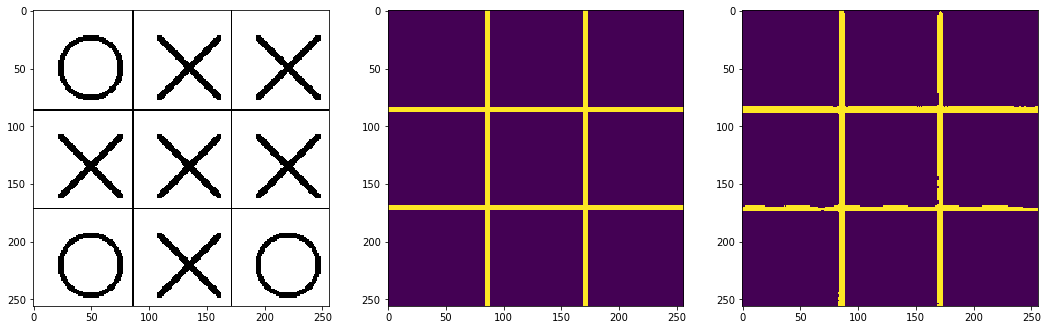


Sample Prediction after epoch 1

Epoch 2/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0044 - mean_iou: 0.9376 - val_loss: 0.0033 - val_mean_iou: 0.9493


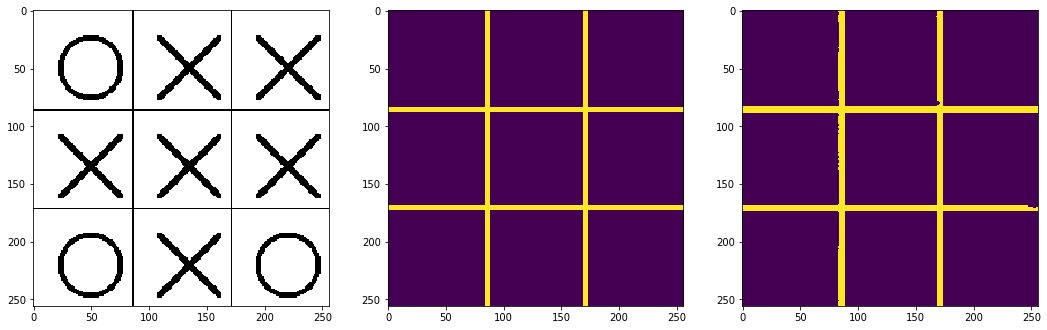


Sample Prediction after epoch 2

Epoch 3/10
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0034 - mean_iou: 0.9560 - val_loss: 0.0032 - val_mean_iou: 0.9609

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


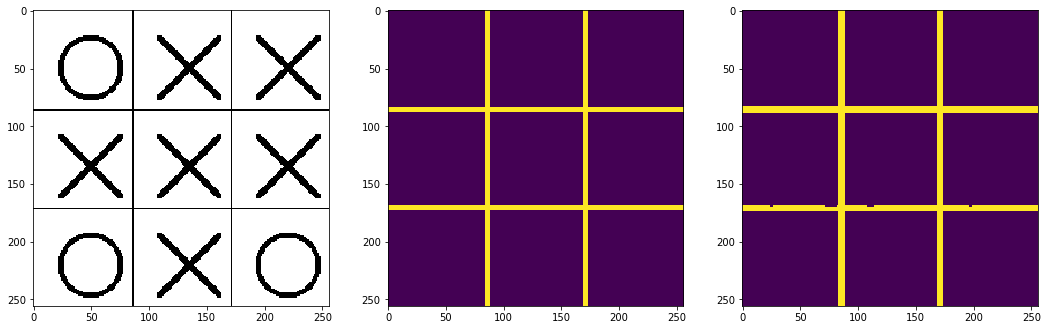


Sample Prediction after epoch 3

Epoch 4/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0016 - mean_iou: 0.9650 - val_loss: 0.0033 - val_mean_iou: 0.9684


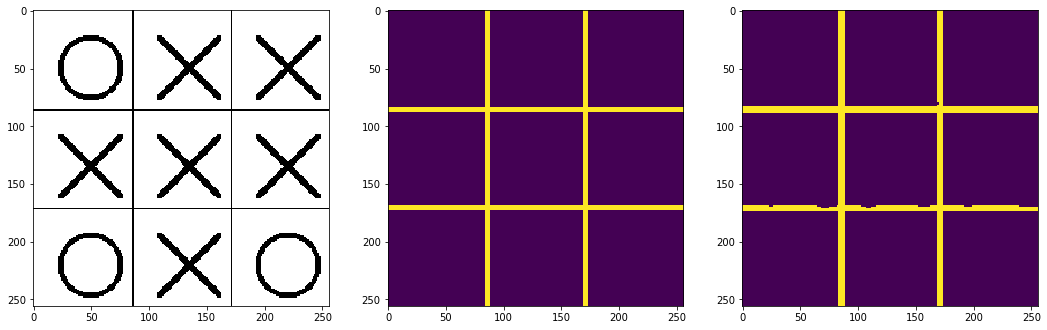


Sample Prediction after epoch 4

Epoch 5/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0013 - mean_iou: 0.9710 - val_loss: 0.0048 - val_mean_iou: 0.9732

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


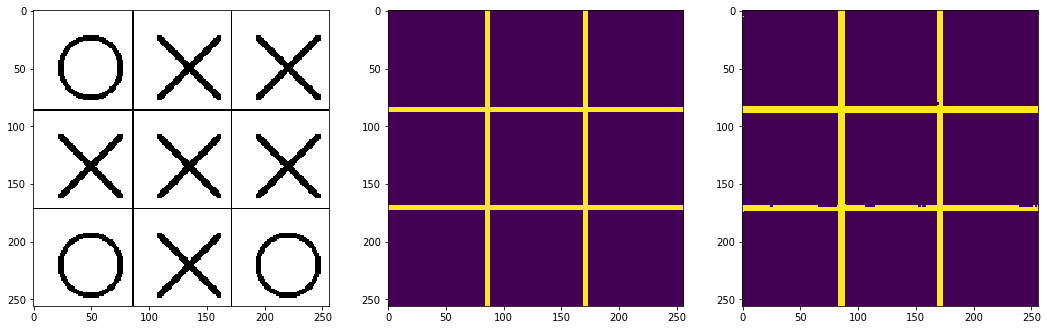


Sample Prediction after epoch 5

Epoch 6/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0011 - mean_iou: 0.9749 - val_loss: 0.0044 - val_mean_iou: 0.9765


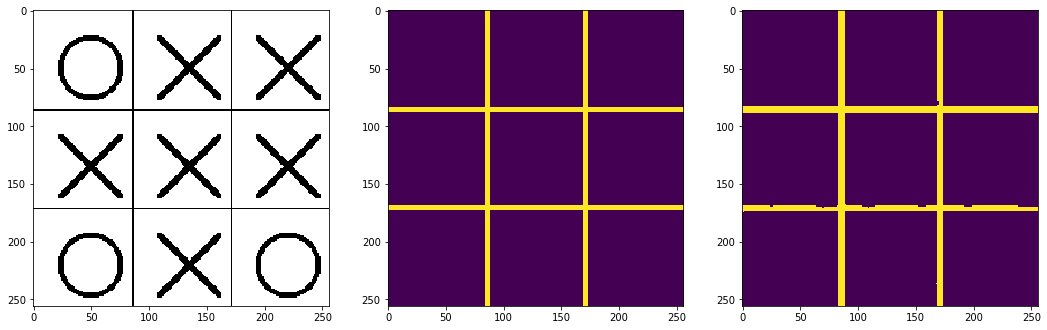


Sample Prediction after epoch 6

Epoch 7/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0011 - mean_iou: 0.9777 - val_loss: 0.0047 - val_mean_iou: 0.9788

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


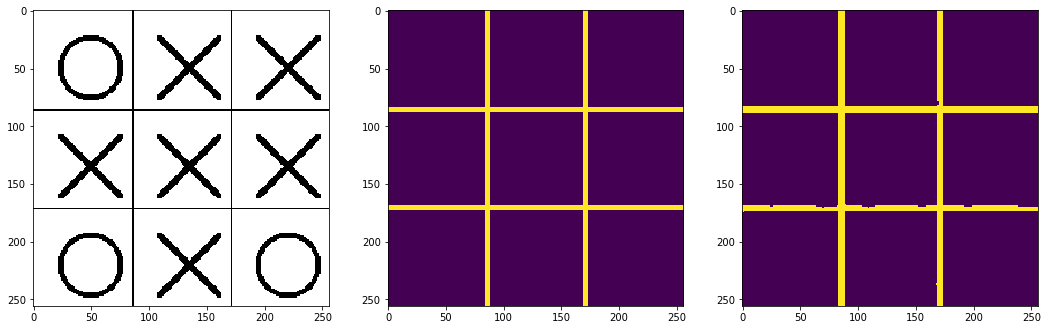


Sample Prediction after epoch 7

Epoch 8/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0010 - mean_iou: 0.9798 - val_loss: 0.0044 - val_mean_iou: 0.9806


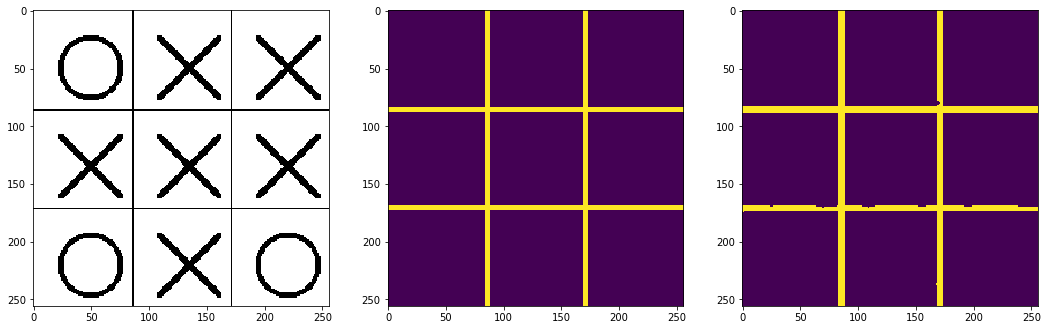


Sample Prediction after epoch 8

Epoch 9/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0010 - mean_iou: 0.9814 - val_loss: 0.0044 - val_mean_iou: 0.9820

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.


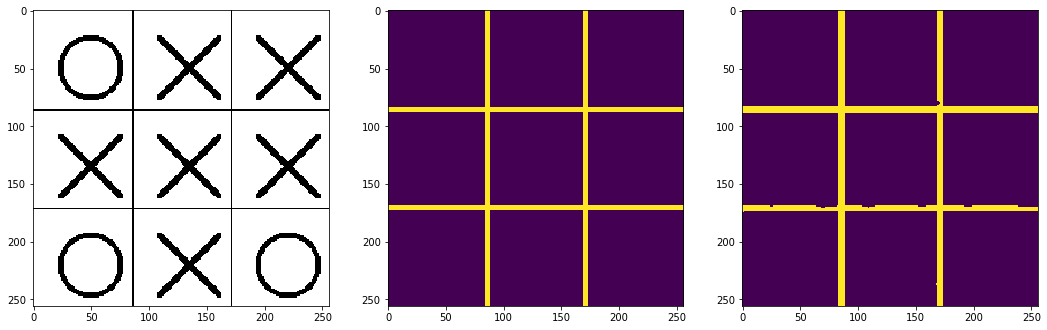


Sample Prediction after epoch 9

Epoch 10/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0010 - mean_iou: 0.9826 - val_loss: 0.0044 - val_mean_iou: 0.9831


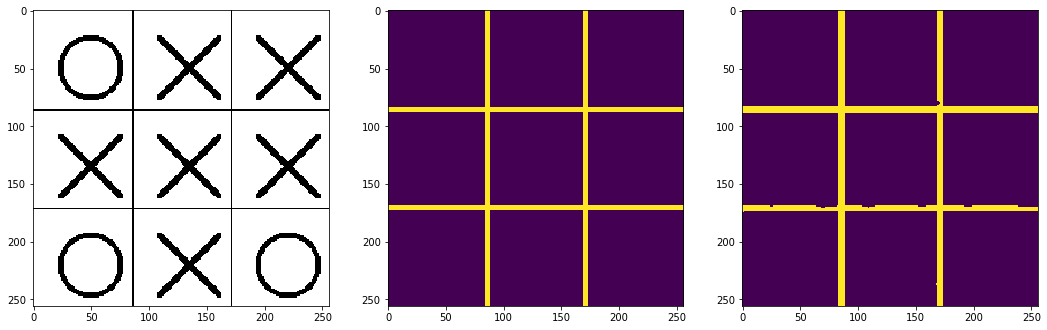


Sample Prediction after epoch 10



In [0]:
history = model.fit_generator(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=1000, callbacks=callbacks_list, workers=2, use_multiprocessing=True, verbose=1)

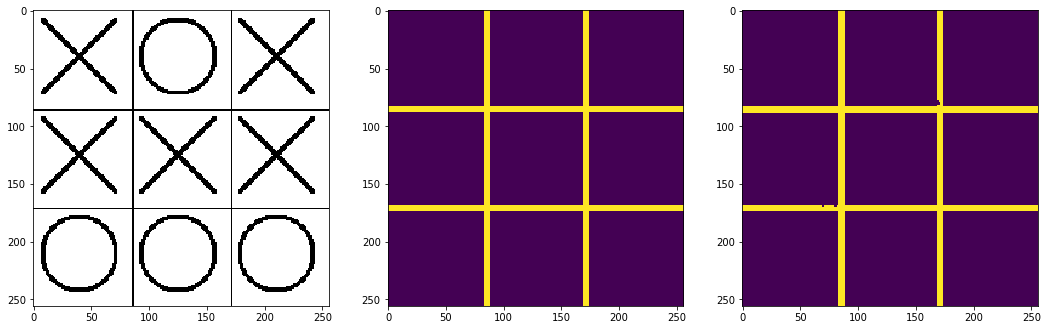

In [0]:
def predict(model, file_name_img, file_name_mask, input_height, input_width,
            n_classes):
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()
    return mask_pred_raw


mask_pred_raw = predict(model, "image_val/tictactoe_29564.png", "mask_borders_val/tictactoe_29564.png", input_height, input_width, n_classes)

In [0]:
model.save(root_path + 'outputs/table_tictactoe_borders.h5')